# ABS Quarterly Dwelling Stock 6432

## Python set-up

In [1]:
# system imports
import textwrap
from functools import cache
from typing import TypedDict

In [2]:
# analytic imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
import pandas as pd
from pandas import DataFrame, PeriodIndex
import readabs as ra
from readabs import metacol as mc

In [3]:
# local imports
from abs_helper import get_abs_data
from plotting import (
    finalise_plot,
    line_plot,
    state_abbr,
    state_colors,
    plot_covid_recovery,
)

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999

# display charts within this notebook
SHOW = True

In [4]:
# Constants
WEEKS_PER_YEAR = 365.24 / 7
WEEKS_PER_YEAR

52.17714285714286

## Get core data from ABS

In [5]:
abs_dict, meta, source, RECENT = get_abs_data("6432.0")
plot_times = None, RECENT
plot_tags = "", "-recent"

In [6]:
# A quick look at table names
textwrap.wrap(", ".join(abs_dict.keys()), width=80)

['643201, 643202']

## Plot headline data

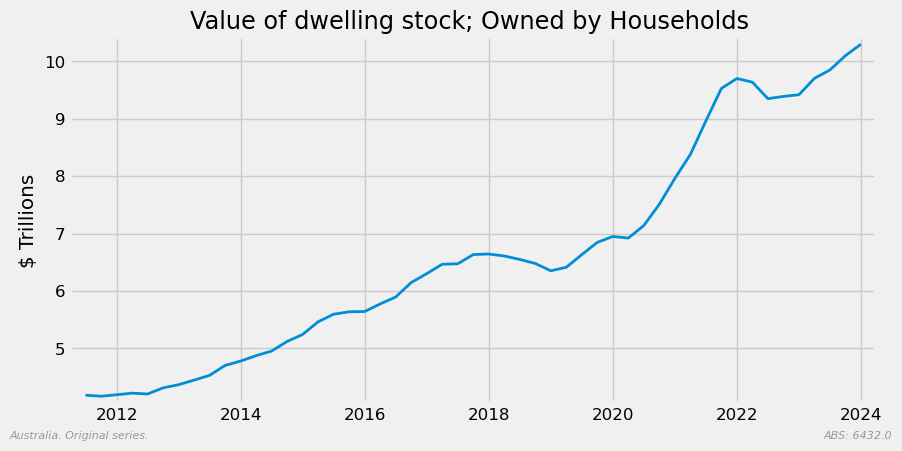

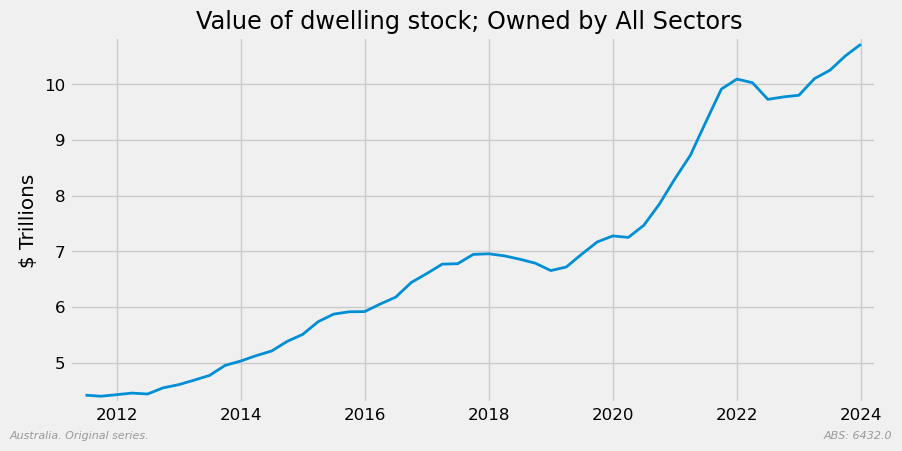

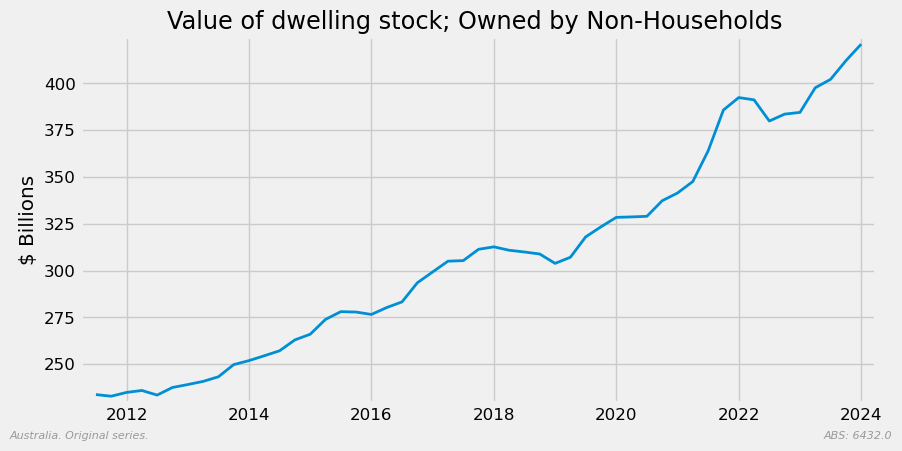

recalibrate(): No adjustments needed


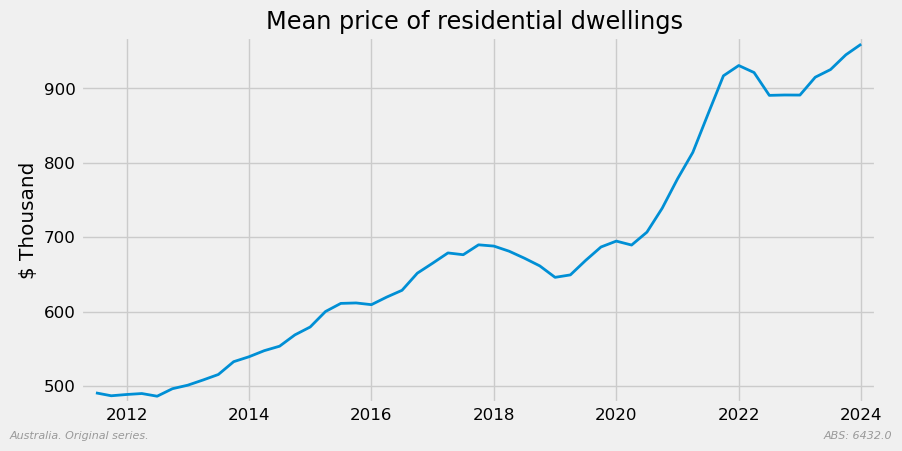

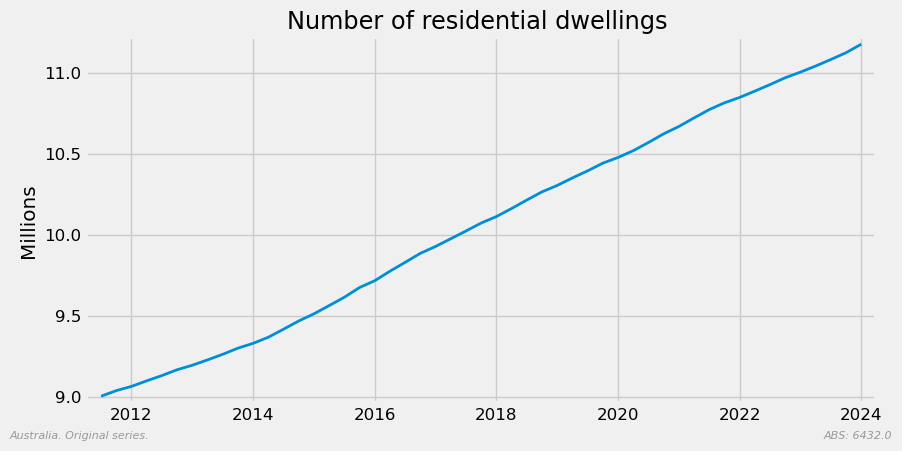

In [7]:
def plot_headline() -> None:
    """Headline charts"""

    table = "643201"
    plotable = [
        "Value of dwelling stock; Owned by Households ;  Australia ;",
        "Value of dwelling stock; Owned by All Sectors ;  Australia ;",
        "Value of dwelling stock; Owned by Non-Households ;  Australia ;",
        "Mean price of residential dwellings ;  Australia ;",
        "Number of residential dwellings ;  Australia ;",
    ]
    data = abs_dict[table]
    for item in plotable:
        search = {item: mc.did}
        _table, series_id, units = ra.find_abs_id(meta, search)
        series, units = ra.recalibrate(data[series_id], units, verbose=True)
        stype = meta[meta[mc.id] == series_id][mc.stype].values[0]

        ax = series.plot(lw=2)
        finalise_plot(
            ax,
            title=item.rsplit(";", maxsplit=2)[0],
            ylabel=units,
            rfooter=source,
            lfooter=f"Australia. {stype} series. ",
            show=SHOW,
        )


plot_headline()

## State data

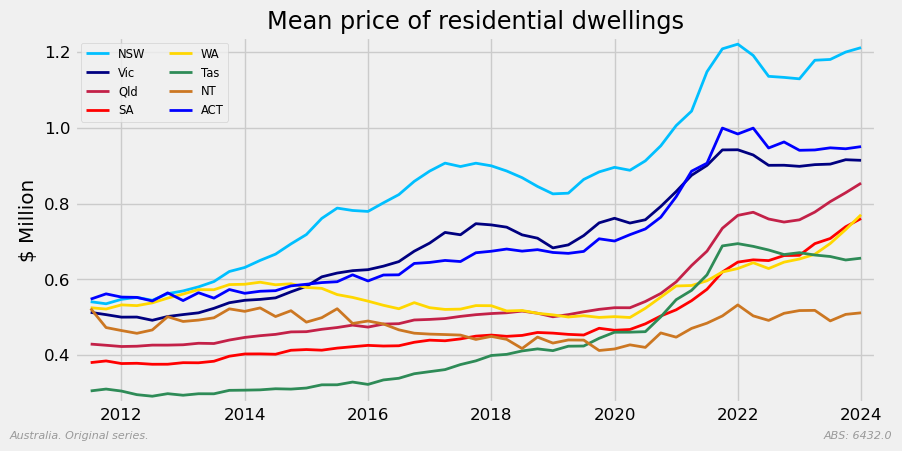

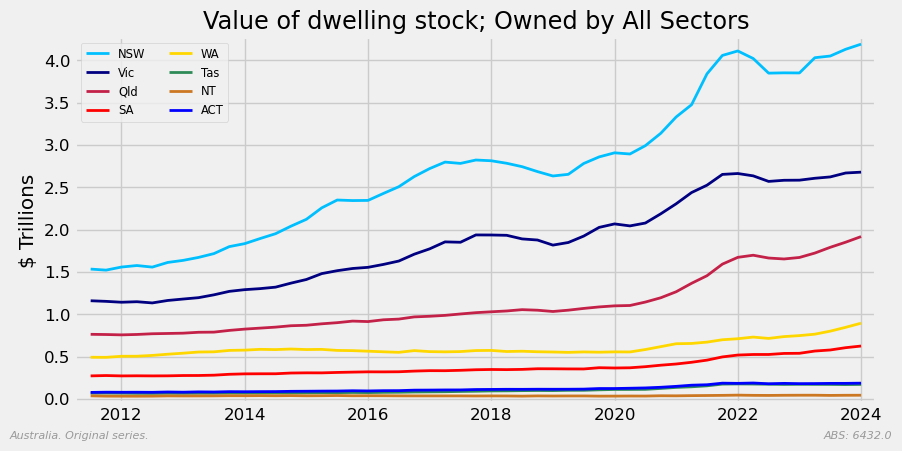

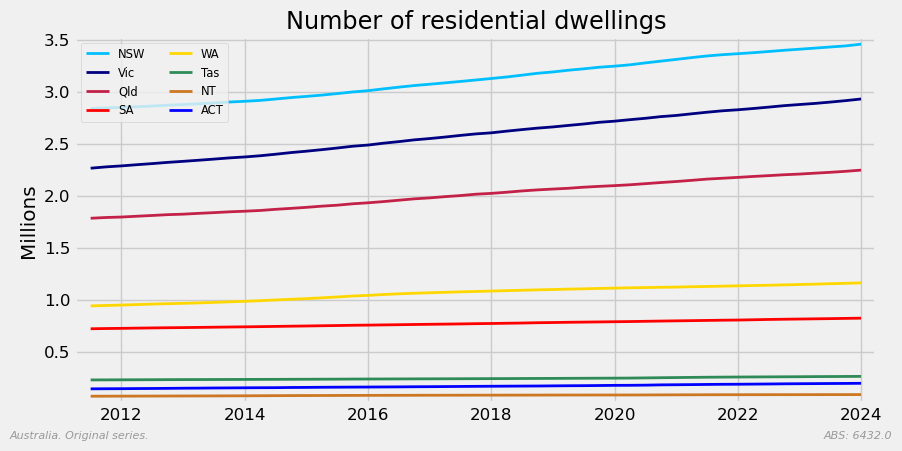

In [8]:
def plot_states():
    table = "643201"
    data = abs_dict[table]
    items = [
        # [identifying name, where the state name can be found],
        ["Mean price of residential dwellings", 1],
        ["Value of dwelling stock; Owned by All Sectors", 2],
        ["Number of residential dwellings", 1],
    ]
    for item, offset in items:
        search = {item: mc.did, table: mc.table}
        rows = ra.search_abs_meta(meta, search)[:-1]  # drop Australia
        states = rows[mc.did].str.split(";").str[offset].str.strip().map(state_abbr)
        colors = states.map(state_colors)
        series_ids = rows[mc.id]
        p_data = data[series_ids].copy()
        p_data.columns = states
        units = rows[mc.unit].values[0]
        series_type = rows[mc.stype].values[0]
        p_data, units = ra.recalibrate(p_data, units)

        line_plot(
            p_data,
            title=item,
            ylabel=units,
            color=list(colors),
            width=2,
            tags="states",
            rfooter=source,
            legend={
                "ncol": 2,
                "loc": "upper left",
                "fontsize": "x-small",
            },
            lfooter=f"Australia. {series_type} series. ",
            show=SHOW,
        )


plot_states()

## Calculate and plot population per dwelling

In [9]:
def get_population() -> tuple[pd.Series, str]:
    """Get latest population estimates from national accounts."""

    cat_id = "5206.0"
    gdp_table = "5206001_Key_Aggregates"
    wanted = {
        "A2302460K": [cat_id, gdp_table, "GDP per capita"],
        "A2302459A": [cat_id, gdp_table, "Gross domestic product"],
    }
    bucket = {}
    for series_id, (cat, seo, label) in wanted.items():
        bucket[label] = ra.read_abs_series(cat, series_id, single_excel_only=seo)[
            0
        ].iloc[:, 0]
    population = bucket["Gross domestic product"] / bucket["GDP per capita"] * 1_000_000
    return population, cat_id


# get_population()

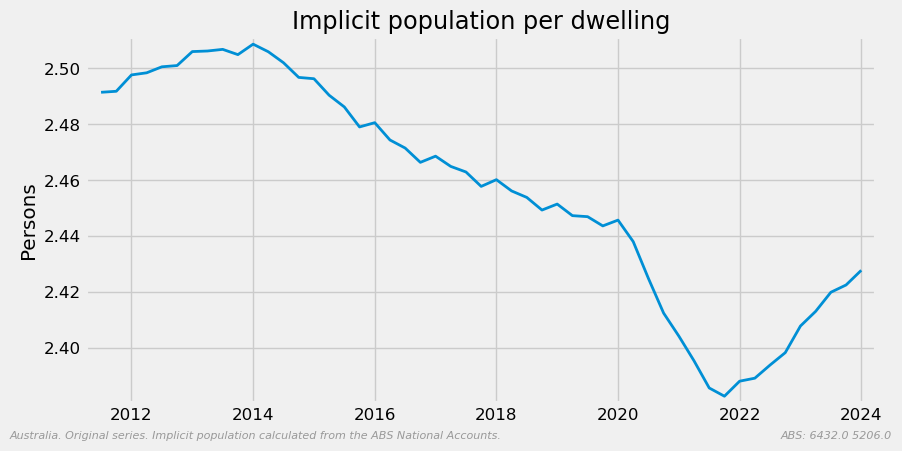

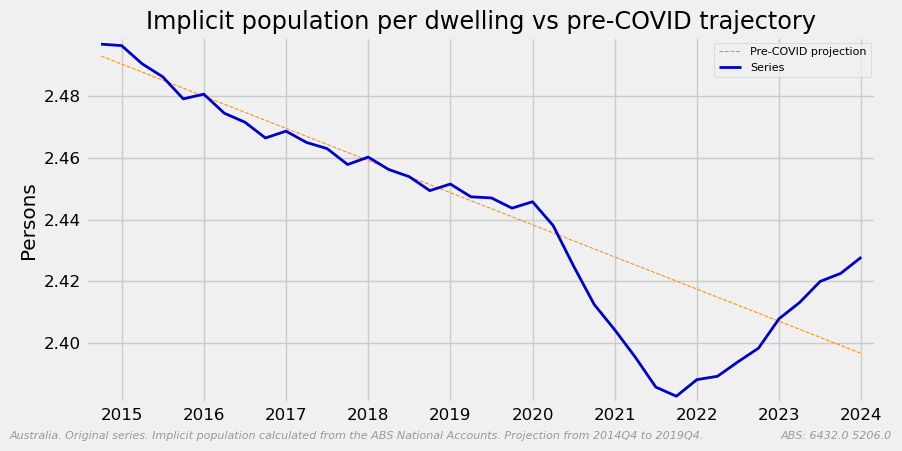

In [10]:
def pop_per_dwelling() -> None:
    """Plot population per dwelling."""

    population, cat_gdp = get_population()

    search = {"Number of residential dwellings ;  Australia ;": mc.did}
    _table, series_id, units = ra.find_abs_id(meta, search)
    assert units in ["Thousands", "000"]
    dwellings = abs_dict["643201"][series_id] * 1_000
    pop_per_dwellings = (population / dwellings).dropna()

    common_annotations = {
        "ylabel": "Persons",
        "rfooter": f"{source} {cat_gdp}",
        "lfooter": "Australia. Original series. "
        + "Implicit population calculated from the ABS National Accounts. ",
        "show": SHOW,
    }

    ax = pop_per_dwellings.plot(lw=2)
    finalise_plot(
        ax,
        title="Implicit population per dwelling",
        **common_annotations,
    )
    plot_covid_recovery(
        pop_per_dwellings,
        title="Implicit population per dwelling vs pre-COVID trajectory",
        **common_annotations,
    )


pop_per_dwelling()

## Calculate and plot mean dwelling value per FT annual ordinary earnings 

In [11]:
def get_mean_value() -> pd.Series:

    search = {"Mean price of residential dwellings ;  Australia ;": mc.did}
    table, series_id, units = ra.find_abs_id(meta, search)
    assert units.strip() in ["$ Thousand", "$'000"]
    mean_value = abs_dict[table][series_id] * 1_000

    return mean_value


# get_mean_value().tail()

In [12]:
def get_annual_earnings() -> tuple[pd.Series, str]:
    """Return Average Annual FT Adult Ordinary Time Earnings for Persons.
    Note: This data is published biannually."""

    cat = "6302.0"
    sid = "A85002148L"
    table = "6302003"
    d, m = ra.read_abs_series(cat, sid, single_excel_only=table)

    return d.iloc[:, 0] * WEEKS_PER_YEAR, cat


# get_annual_earnings()

In [13]:
def q_nov_to_dec(series: pd.Series) -> pd.Series:
    return series.to_timestamp(how="end").to_period(freq="Q-DEC")

In [14]:
def mean_dwelling_value_per_earnings() -> None:
    """Plot mean dwelling value per average annual FT ordinary time earnings."""

    earnings, cat_awe = get_annual_earnings()
    earnings = q_nov_to_dec(earnings)
    mean_value = get_mean_value()
    value_per_earnings = (mean_value / earnings).dropna()

    ax = value_per_earnings.plot(lw=2)
    finalise_plot(
        ax,
        title="Mean dwelling value / Annual ave FT ordinary earnings",
        ylabel="Multiples",
        rfooter=f"{source} {cat_awe}",
        lfooter="Australia. Original series. ",
        show=SHOW,
    )

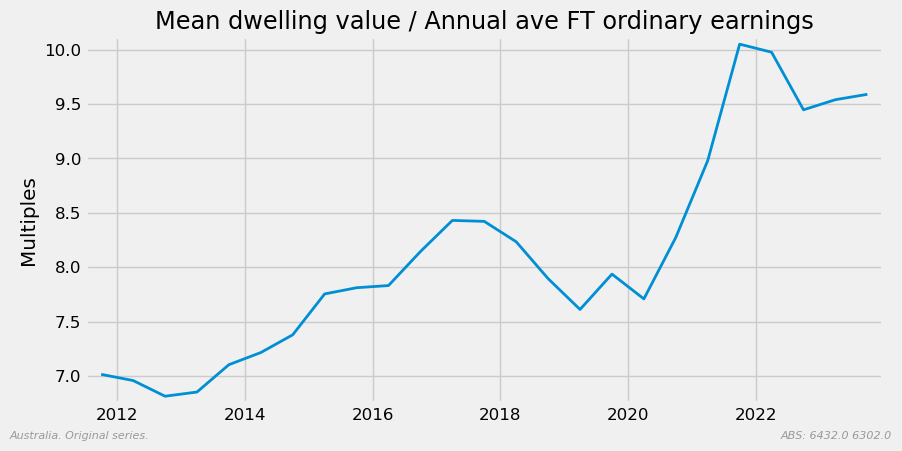

In [15]:
mean_dwelling_value_per_earnings()

## Housing repayment affordability
Weekly loan repayment as a percent of weekly income

In [16]:
@cache
def get_interest_rates() -> dict[str, pd.Series]:

    table = "F5"
    data, meta = ra.read_rba_table(table)
    print("RBA datatype for index", data.index.dtype)
    desired = (
        "Lending rates; Housing loans; Banks; Variable; Standard; Owner-occupier",
        "Lending rates; Housing loans; Banks; Variable; Discounted; Owner-occupier",
        "Lending rates; Housing loans; Banks; 3-year fixed; Owner-occupier",
    )
    ret = {}
    for d in desired:
        column = meta[meta.Title == d]["Series ID"].values[0]
        title = d.split(";", maxsplit=2)[-1].strip()
        ret[title] = data[column]  # ra.monthly_to_qtly()

    return ret


#get_interest_rates()  #

In [17]:
class Assumptions(TypedDict):
    loan_to_value: int  # percent
    loan_term: int  # years
    repayment_freq: float  # weeks


def calculate_repayments(
    a: Assumptions,
    dwelling_value: pd.Series,
    weekly_earnings: pd.Series,
    loan_rates: dict[str, pd.Series],
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Based on assumptions, calculate the repayments for a new loan
    at the time the loan was made. Return a tuple of DataFrames.
    The first DataFrame is weekly repayment amounts in nominal $,
    The second DataFrane is weekly repayment amounts as a % of AWE."""

    # preliminaries
    n_per_year = WEEKS_PER_YEAR / a["repayment_freq"]  # repayments per year
    n_per_term = a["loan_term"] * n_per_year  # repayments per loan term
    principal = dwelling_value * a["loan_to_value"] / 100.0

    # calculate - weekly repayments in nominal $, and as a % of AWE
    repayment_to_income = pd.DataFrame()
    weekly_repayment = pd.DataFrame()
    for label, series in loan_rates.items():
        period_rate = series / 100.00 / n_per_year  # convert percent to rate
        period_payment = (
            (period_rate * principal) / (1 - (1 / (1 + period_rate) ** n_per_term))
        ).dropna()
        weekly_payment = period_payment / a["repayment_freq"]
        weekly_repayment[label] = weekly_payment
        repayment_to_income[label] = weekly_payment / weekly_earnings.asfreq("Q-DEC") * 100.0

    return weekly_repayment, repayment_to_income


#a = {'loan_to_value': 80, 'loan_term': 30, 'repayment_freq': 52}
#dwelling_value = get_mean_value()
#weekly_earnings, cat_awe = get_annual_earnings()
#weekly_earnings = weekly_earnings / WEEKS_PER_YEAR
#loan_rates = get_interest_rates()
#nom, repay_to_income = calculate_repayments(a, dwelling_value, weekly_earnings, loan_rates)


In [18]:
def triangle(series: pd.Series) -> pd.DataFrame:
    """Convert a Series into a lower-left-triangle DataFrame."""

    return (
        pd.DataFrame(np.diag(series), index=series.index, columns=series.index)
        .astype(float)
        .replace(0.0, np.nan)
        .ffill()
    )

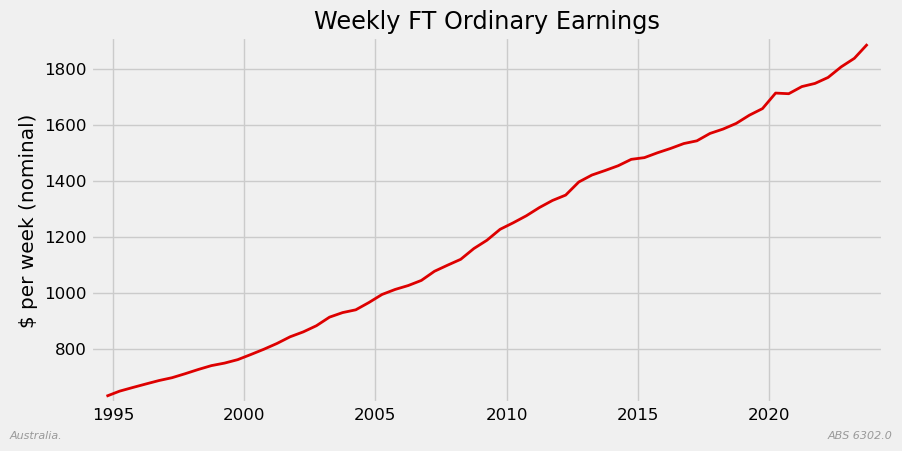

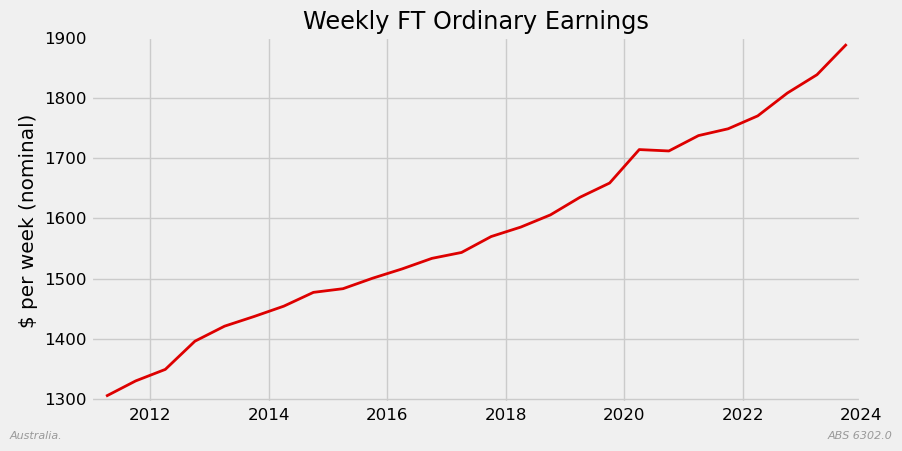

cache_only=False verbose=False
RBA datatype for index period[M]


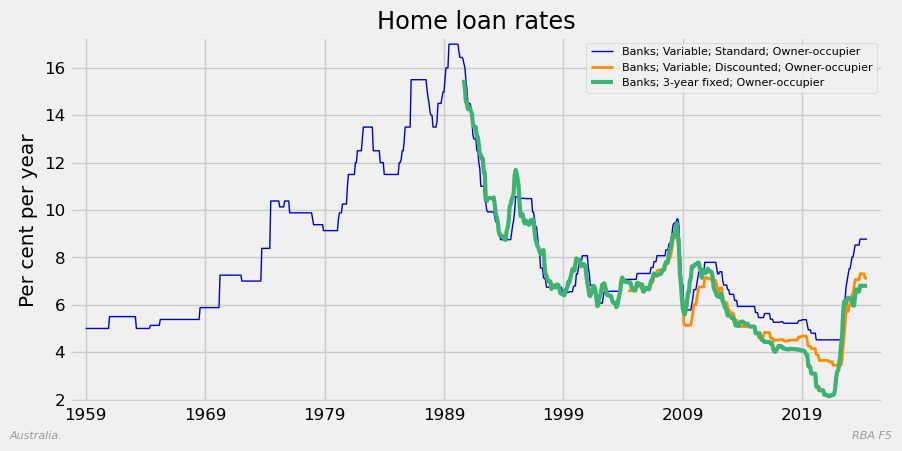

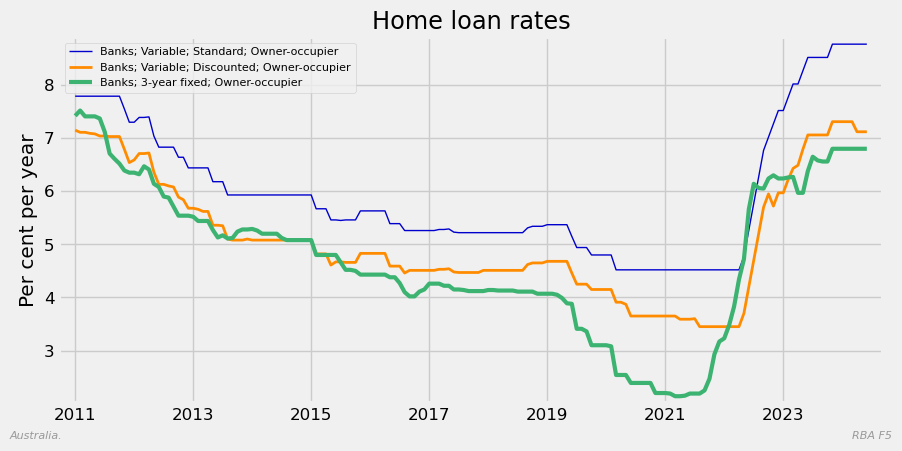

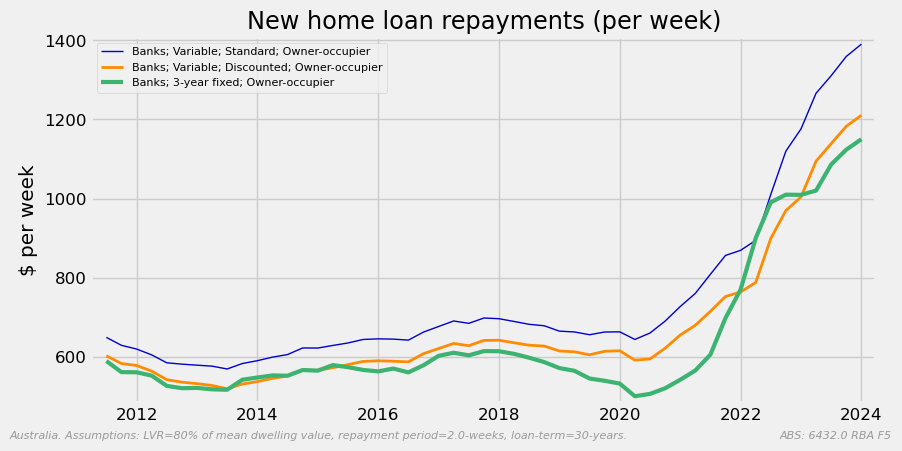

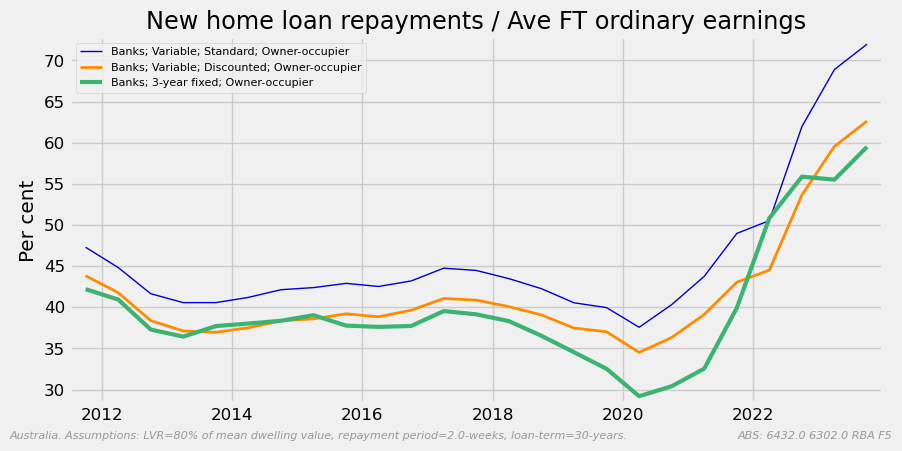

In [19]:
def prelim_affordability() -> None: 
    """Preliminary affordability analysis."""


    # plot - weekly FT ordinary earnings
    annual_earnings, cat_awe = get_annual_earnings()  # PeriodIndex = Q-NOV
    annual_earnings = q_nov_to_dec(annual_earnings)  # PeriodIndex = Q-DEC
    weekly_earnings = (annual_earnings / WEEKS_PER_YEAR).dropna()
    line_plot(
        weekly_earnings,
        starts=(None, pd.Period("2011-01-01", freq="Q")),
        width=2,
        title="Weekly FT Ordinary Earnings",
        ylabel="$ per week (nominal)",
        rfooter=f"ABS {cat_awe}",
        lfooter=f"Australia.",
        show=SHOW,
    )


    # plot - lending rates from the RBA
    orig_loan_rates = get_interest_rates() 
    indicator_rates = pd.DataFrame(orig_loan_rates)
    line_plot(
        indicator_rates,
        starts=(None, pd.Period("2011-01-01", freq="M")),
        title="Home loan rates",
        ylabel="Per cent per year",
        width=[1, 2, 3],
        rfooter=f"RBA F5",
        lfooter=f"Australia.",
        show=SHOW,
    )
    indicator_rates = indicator_rates[~indicator_rates.index.duplicated(keep="last")]
    loan_rates = ra.monthly_to_qtly(indicator_rates, f="mean") 


    # --- calculate what a new loan would cost, subject to assumptions
    assumptions: Assumptions = {
        "loan_to_value": 80,  # percent
        "loan_term": 30,  # years
        "repayment_freq": 2.0,  # weeks
    }
    assumptions_text = (
        f"Assumptions: LVR={assumptions['loan_to_value']}% of mean dwelling value, "
        f"repayment period={assumptions['repayment_freq']}-weeks, "
        f"loan-term={assumptions['loan_term']}-years. "
    )

    # Calculate
    mean_dwelling_value  = get_mean_value()
    weekly_repayment, repayment_to_income = calculate_repayments(
        assumptions, mean_dwelling_value, weekly_earnings, loan_rates
    )

    # plot - weekly repayments in nominal $
    line_plot(
        weekly_repayment,
        title="New home loan repayments (per week)",
        width=[1, 2, 3],
        ylabel="$ per week",
        rfooter=f"{source} RBA F5",
        lfooter=f"Australia. {assumptions_text}",
        show=SHOW,
    )

    # plot - repayments as a % of average ordinary full-time ordinary earnings
    line_plot(
        repayment_to_income.dropna(how="all"),
        title="New home loan repayments / Ave FT ordinary earnings",
        ylabel="Per cent",
        width=[1, 2, 3],
        rfooter=f"{source} {cat_awe} RBA F5",
        lfooter=f"Australia. {assumptions_text}",
        show=SHOW,
    )

    return assumptions, assumptions_text, loan_rates, mean_dwelling_value, weekly_earnings, cat_awe



_ = prelim_affordability()

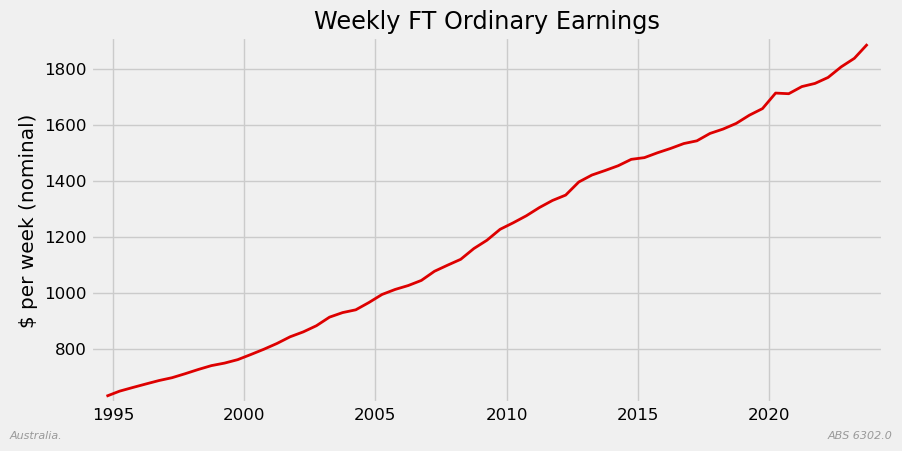

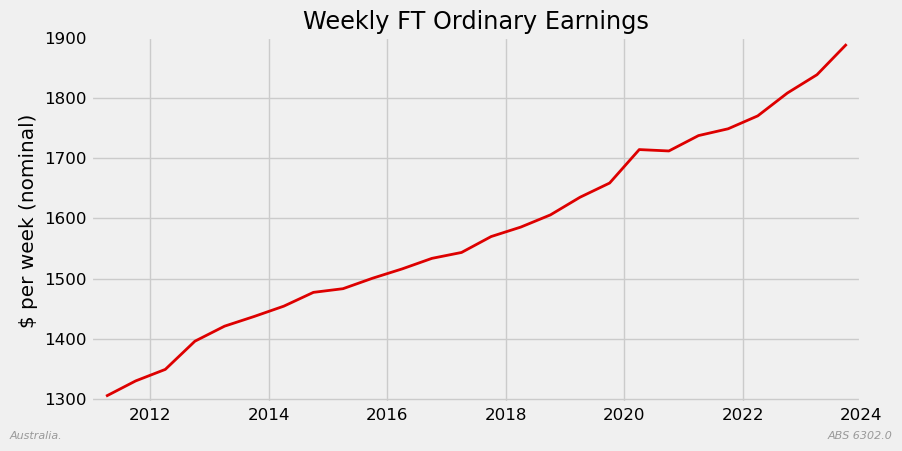

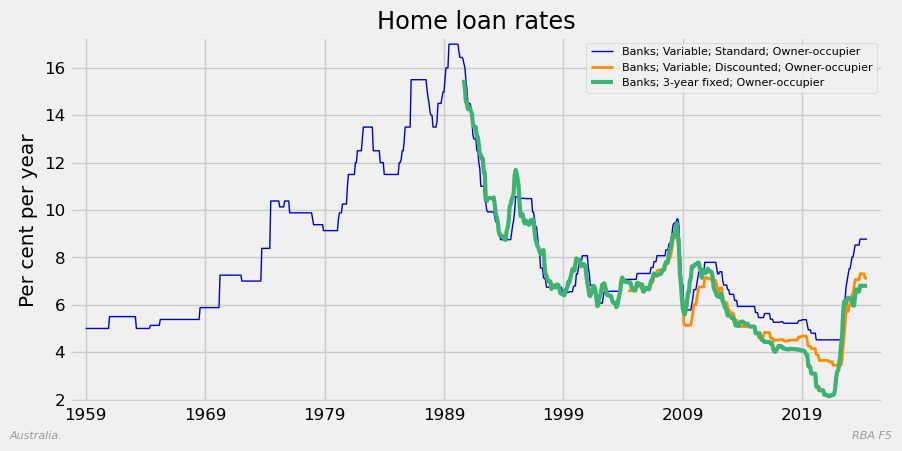

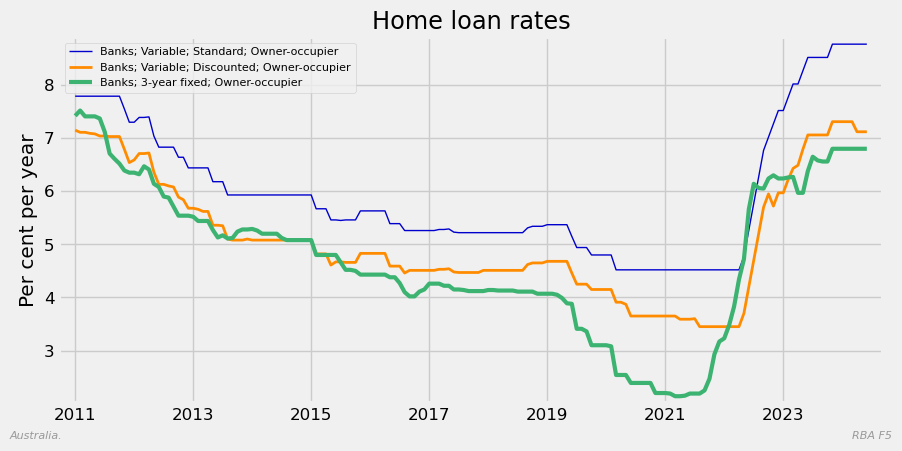

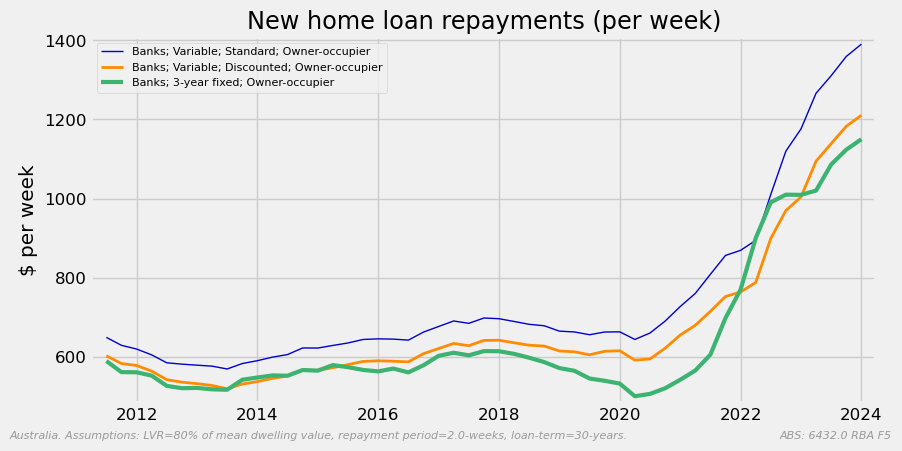

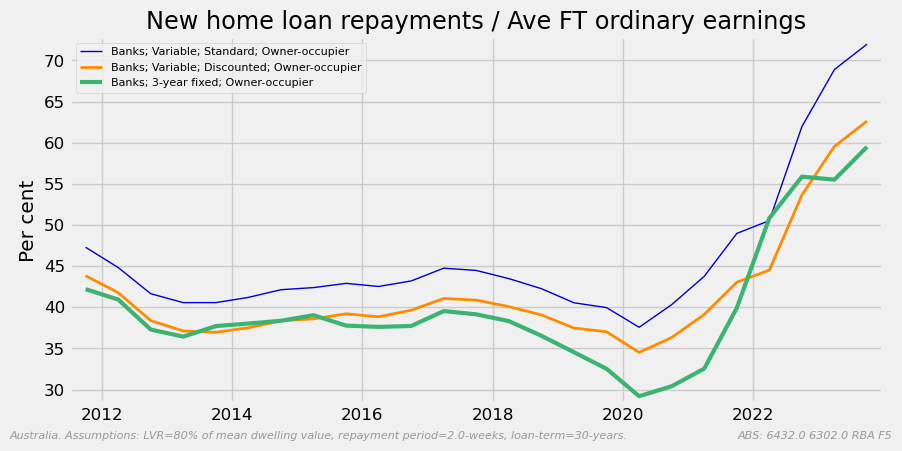

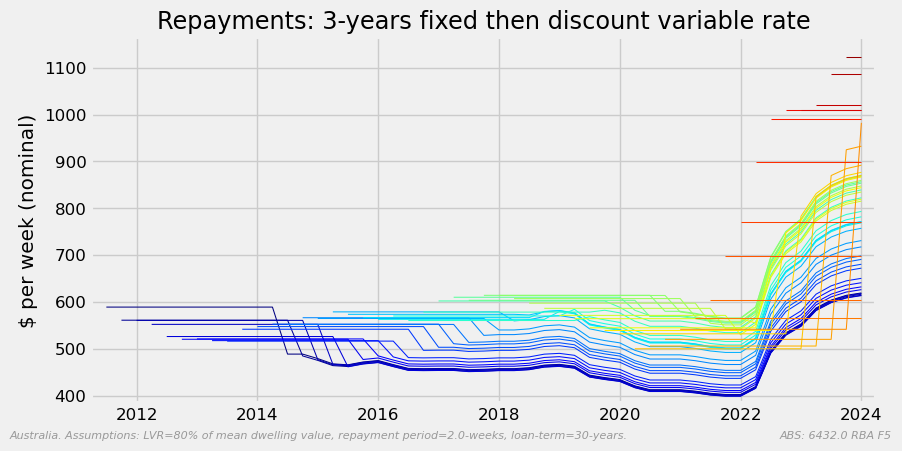

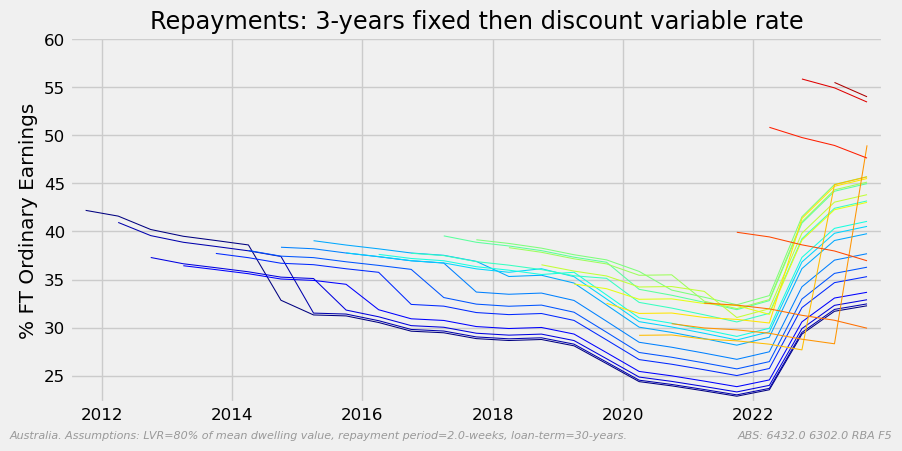

In [20]:
def repayment_affordability():
    """Bill shock analysis."""

    # --- preliminaries
    assumptions, assumptions_text, loan_rates, mean_dwelling_value, weekly_earnings, cat_awe = prelim_affordability()

    # ---- Bill Shock
    # let's think about bill-shock with a three year
    # fixed term loan followed by discount variable rate.

    # create starting point dwelling_values (assumed purchase price)
    v = mean_dwelling_value
    purchase_price = triangle(v)
    nominal = pd.DataFrame(index=v.index)
    standardised = pd.DataFrame(index=v.index)
    standardised = standardised[standardised.index.quarter.isin((2, 4))]

    # create fixed rates
    fixed_col = "Banks; 3-year fixed; Owner-occupier"
    fr = loan_rates[fixed_col].dropna()
    fr = fr[fr.index >= purchase_price.index[0]].copy()
    fixed_rates = triangle(fr)

    # calculate payment regime
    fixed_years = 3
    var_col = "Banks; Variable; Discounted; Owner-occupier"
    for col in purchase_price.columns:
        lr = {fixed_col: fixed_rates[col], var_col: loan_rates[var_col].dropna()}

        nom, stdz = calculate_repayments(
            assumptions, purchase_price[col], weekly_earnings, lr
        )

        fixed_period = pd.period_range(start=col, periods=fixed_years * 4).intersection(
            purchase_price.index
        )
        nominal.loc[fixed_period, col] = nom.loc[fixed_period, fixed_col]
        nominal[col] = nominal[col].where(nominal[col].notna(), other=nom[var_col])

        if col not in standardised.index:
            continue

        fixed_period = fixed_period.intersection(standardised.index)
        standardised.loc[fixed_period, col] = stdz.loc[fixed_period, fixed_col]
        standardised[col] = standardised[col].where(
            standardised[col].notna(), other=stdz[var_col]
        )

    # - plot bill-shock in nominal $
    colors = [
        mpl.colors.rgb2hex(x)
        for x in plt.cm.jet(np.linspace(0, 1, len(nominal.columns)))
    ]
    line_plot(
        nominal,
        title=f"Repayments: {fixed_years}-years fixed then discount variable rate",
        ylabel="$ per week (nominal)",
        rfooter=f"{source} RBA F5",
        lfooter=f"Australia. {assumptions_text}",
        color=colors,
        legend=False,
        show=SHOW,
    )

    # - plot bill-shock in % AWE terms
    colors = [
        mpl.colors.rgb2hex(x)
        for x in plt.cm.jet(np.linspace(0, 1, len(standardised.columns)))
    ]
    line_plot(
        standardised,
        title=f"Repayments: {fixed_years}-years fixed then discount variable rate",
        ylabel="% FT Ordinary Earnings",
        rfooter=f"{source} {cat_awe} RBA F5",
        lfooter=f"Australia. {assumptions_text}",
        tags="standardized",
        color=colors,
        legend=False,
        show=SHOW,
    )


repayment_affordability()


## Finished

In [21]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Jul 17 2024 21:34:02

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

numpy     : 1.26.4
pandas    : 2.2.2
readabs   : 0.0.12a2
matplotlib: 3.9.1

Watermark: 2.4.3



In [22]:
print("Finished")

Finished
